In [190]:
import torch
import numpy as np 
import torchvision
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from tqdm import trange

from datautils import load_mnist

def load_data(name, pos_class, neg_class):
	subset_labels = (pos_class, neg_class)
	train_loader, test_loader = load_mnist(batch_size=32, flatten=True, subset_labels=subset_labels)	
	return train_loader.dataset.tensors, test_loader.dataset.tensors

def create_model(**kwargs):
	# C = 1.0 / (self.num_train_examples * self.weight_decay)
	return LogisticRegression(
		# C=C,
        # penalty="l2",
		tol=1e-8,
		fit_intercept=False,
		solver="lbfgs",
		warm_start=True,
		max_iter=1000,
		**kwargs,
	)
	
def train_model(model, x_train, y_train, x_test, y_test):
	model.fit(x_train, y_train)

	y_pred = model.predict(x_train)
	train_acc = accuracy_score(y_train, y_pred) 

	y_pred = model.predict(x_test)
	test_acc = accuracy_score(y_test, y_pred)
	print(f"train acc: {train_acc:.4f}, test acc: {test_acc:.4f}")

def sigmoid(x): return 1 / (1 + torch.exp(-x))

In [191]:
# import torch.nn as nn 

# class LogisticRegression(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc = nn.Linear(784, 1)
#         self.sigmoid = nn.Sigmoid()
    
#     def compute_cost(self, x, y):
#         return torch.sum(torch.log(1 + torch.exp(-y.unsqueeze(1) * (x @ model.fc.weight.T)))) / len(x)

#     def compute_grad(self, x, y):
#         return x.T @ (-self.sigmoid(-y.unsqueeze(1) * (x @ self.fc.weight.T)) * y.unsqueeze(1))

#     def compute_hessian(self, x, y):
#         return self.sigmoid(x @ self.fc.weight.T)
        
#     def forward(self, x):
#         return self.sigmoid(self.fc(x))

# model = LogisticRegression()
# # model(x_train)
# model.compute_cost(x_train, y_train)
# # model.compute_grad(x_train, y_train).shape
# model.compute_hessian(x_train, y_train).shape

train acc: 0.9982, test acc: 0.9949
hessian min eigval 0.009999999776482582
hessian max eigval 0.09309239685535431


100%|████████████████████████████████████████████████████████████████| 13007/13007 [00:00<00:00, 16802.26it/s]


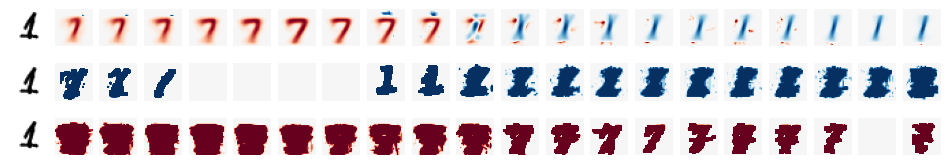

In [230]:
# pos_class, neg_class = 0, 1
pos_class, neg_class = 1, 7
# pos_class, neg_class = 4, 7 ## works well

(x_train, y_train), (x_test, y_test) = load_data("MNIST", pos_class, neg_class)

# transform labels
y_train = torch.where(y_train==pos_class, 0., 1.)
y_test = torch.where(y_test==pos_class, 0., 1.)

model = create_model()
train_model(model, x_train, y_train, x_test, y_test) 
W = torch.tensor(model.coef_.T, dtype=torch.float)
z = x_train @ W
h = sigmoid(z)

d_ii = (h*(1-h)).squeeze()
D = torch.diag(d_ii)

y_target = y_test
y_pred = torch.tensor(model.predict_proba(x_test)[:,1]).to(torch.float)
test_loss = torch.nn.functional.binary_cross_entropy(y_pred, y_target, reduction="none")

_test_loss_pos_class = np.where(y_test==0, test_loss, np.nan)
test_idx = np.nanargmin(_test_loss_pos_class)
# test_idx = np.nanargmax(_test_loss_pos_class)
# test_idx = 1700
# test_idx = 1413

damp = 1e-2

hess = (x_train.T @ D @ x_train) / len(x_train) + damp * torch.eye(len(W))
inv_hess = torch.inverse(hess)
eigvals = np.linalg.eigvalsh(hess.cpu().numpy())
print(f"hessian min eigval {np.min(eigvals).item()}")
print(f"hessian max eigval {np.max(eigvals).item()}")


xt = x_test[test_idx].reshape(1,-1)
yt = y_test[test_idx] * 2 - 1

influences = []
for i in trange(len(x_train)):
    xtt = x_train[i].reshape(1,-1)
    ytt = y_train[i] * 2 - 1

    score = (yt * ytt * sigmoid(-yt * xt @ W) * sigmoid(-ytt * xtt @ W) * xt @ inv_hess @ xtt.T) / len(x_train)
    influences.append(score) ## order = indices

influences = torch.tensor(influences)
# values, indices = torch.sort(influences.abs())
values, indices = torch.sort(influences)


# plot influential samples

split_k = 20
_, axes = plt.subplots(ncols=split_k+1, nrows=3, figsize=(12,2))

axes[0][0].imshow(x_test[test_idx].reshape(28,28), cmap="gray_r")
axes[0][0].axis("off")

axes[1][0].imshow(x_test[test_idx].reshape(28,28), cmap="gray_r")
axes[1][0].axis("off")

axes[2][0].imshow(x_test[test_idx].reshape(28,28), cmap="gray_r")
axes[2][0].axis("off")

influential_samples = np.array_split(indices, split_k)
# influential_samples = np.array_split(indices, 500)
# influential_samples = influential_samples[:10] + influential_samples[-10:]
for i, samples in enumerate(influential_samples, start=1): 
    sgns = torch.where(y_train[samples] == y_test[test_idx], 1, -1).reshape(-1,1,1)  
    avg_sample = torch.mean(x_train[samples].reshape(-1,28,28) * sgns, axis=0)
    max_sample = torch.max(x_train[samples].reshape(-1,28,28) * sgns, axis=0).values
    min_sample = torch.min(x_train[samples].reshape(-1,28,28) * sgns, axis=0).values
    
    norm = mcolors.TwoSlopeNorm(vcenter=0)
    axes[0][i].imshow(avg_sample, cmap="RdBu", norm=norm)
    axes[0][i].axis("off")

    axes[1][i].imshow(max_sample, cmap="RdBu", norm=norm)
    axes[1][i].axis("off")

    axes[2][i].imshow(min_sample, cmap="RdBu", norm=norm)
    axes[2][i].axis("off")

In [203]:
qts = torch.quantile(values, q=torch.linspace(0, 1, 101))

In [211]:
qts[-2:]

tensor([2.6115e-12, 1.6469e-11])

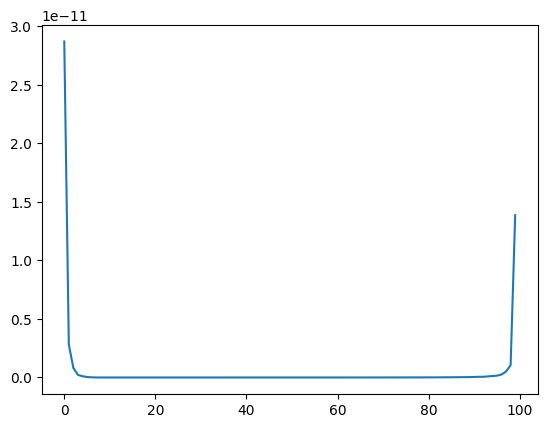

In [216]:
plt.plot(qts.diff(1))

In [119]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(x_train)
kmeans.labels_, kmeans.cluster_centers_

(array([1, 1, 1, ..., 1, 0, 1], dtype=int32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [101]:
kmeans.predict(x_test[test_idx].reshape(1,-1))

array([1], dtype=int32)

np.float64(64.38578189130799)

In [113]:
dists = []
for i in range(len(x_test)):
    dist = ((kmeans.cluster_centers_[0] - x_test[i].numpy()) ** 2).sum()
    dists.append(dist)

In [114]:
max(dists)

np.float64(90.13763271989555)

In [115]:
torch.sort(torch.tensor(dists))

torch.return_types.sort(
values=tensor([16.6645, 17.2079, 17.7722,  ..., 86.4661, 87.6277, 90.1376],
       dtype=torch.float64),
indices=tensor([1413,  875,  427,  ..., 1271,  635, 1700]))